# **Lab 6: Convolutional Neural Networks**
### Authors: Will Lahners, Edward Powers, and Nino Castellano

## **Describing the Data**

Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset/data

## Preparation (3 points total)

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import matplotlib.pyplot as plt  

data = {'path': [], 'label': []}

# Define the root path of our dataset
root_path = "Car-Bike-Dataset"

# Get the subfolders (Car and Bike)
folders = os.listdir(root_path)
for folder in folders:
    folder_path = os.path.join(root_path, folder)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data['path'].append(file_path)
        data['label'].append(folder)

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Encode labels using LabelEncoder (Car: 0, Bike: 1)
le = LabelEncoder()
df['class'] = le.fit_transform(df['label'])

# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define image size for resizing
h, w = 100, 100

# Create a list to store resized and grayscaled images
table_data = []

# Iterate through each image
for i, row in shuffled_df.iterrows():
    img_path = row['path']
    img = cv2.imread(img_path)
    res_img = cv2.resize(img, dsize=(h, w))
    gray_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2GRAY)
    gray_img_with_channel = np.expand_dims(gray_img, axis=-1)  
    table_data.append(gray_img_with_channel) 

# Convert the image data to a NumPy array
X = np.array(table_data)
y = shuffled_df['class']
labels = shuffled_df['label']

# Code credit to us

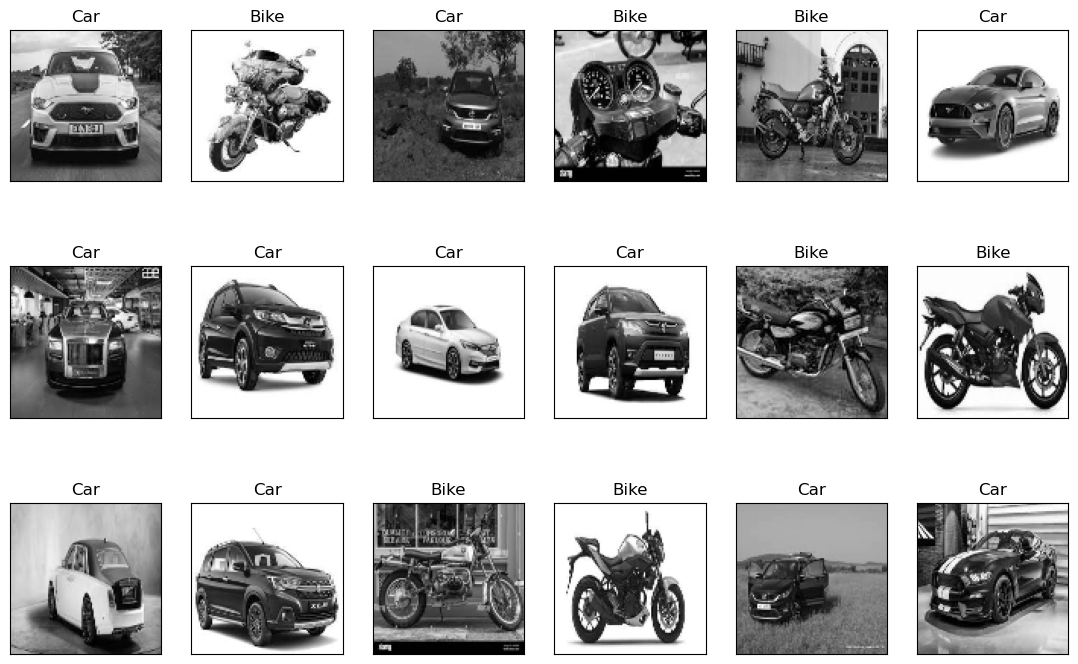

In [2]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Assuming labels is a list of 'Car' and 'Bike' labels
plot_gallery(X, labels, h, w)

# Code credit to us

> [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

**EDDIE**

Recommended Metric: F1-Score
In this scenario, both precision and recall are important:
Precision: We want to ensure that when the model identifies a vehicle as a car, it is indeed a car. Misclassifying a bike as a car could lead to incorrect traffic light timing or inaccurate traffic flow analysis.
Recall: We also want to ensure that the model correctly identifies most cars. Missing cars could lead to underestimation of traffic volume and congestion, impacting traffic management decisions.
The F1-score balances precision and recall, making it a suitable choice when both aspects are crucial. It provides a single score that reflects the overall accuracy and robustness of the model.

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

A stratified K-fold cross-validation with K=10 offers a robust and realistic approach to evaluating the performance of our car vs. bike classification model. It ensures that the model is tested on diverse data, reflects the real-world scenario of encountering a continuous stream of images, and mitigates potential biases due to class imbalances.

In [4]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

# Define the number of folds and batch size
k = 10
batch_size = 128

# Create a StratifiedKFold object
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the datasets for each fold
train_datasets = []
test_datasets = []

# Create datasets for each fold
for train_index, test_index in skfold.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create TensorFlow datasets
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train.batch(batch_size).prefetch(batch_size)
    train_datasets.append(ds_train)

    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    ds_test = ds_test.batch(batch_size).prefetch(batch_size)
    test_datasets.append(ds_test)

2024-04-21 23:05:37.450292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 23:05:37.450504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 23:05:37.459526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 23:05:37.459625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 23:05:37.459695: I tensorflow/compile

## Modeling (6 points total)



> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

**Architecture 1: Baseline CNN**

*Model 1A (Baseline):*
Convolutional Layers: 2 layers with 32 filters each, (3, 3) kernel size
Dense Layer: 128 units
Dropout: 0.5
*Model 1B (More Filters):*
Convolutional Layers: 2 layers with 64 filters each, (3, 3) kernel size
Dense Layer: 128 units
Dropout: 0.5

**Architecture 2: ResNet**

*Model 2A (Basic ResNet):*
Similar to the ResNet example provided in class, with 2 residual blocks.
Filters: 32 in the initial layers, 64 in the residual blocks.
Dense Layer: 256 units
Dropout: 0.25 before the dense layer, 0.5 before the output layer.
*Model 2B (Deeper ResNet):*
Add one more residual block to Model 2A, increasing the network depth.
Keep the filter sizes and dense layer configuration the same.
Dropout: 0.25 before each dense layer.

### **Model 1A:** (3, 3) kernel size, 32 filters each

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Define the model
model = Sequential()

# Data Augmentation Layers
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(RandomContrast(0.1))

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(h, w, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Classification Layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))  # Output layer

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


In [8]:
# Lists to store metrics for each fold
fold_f1_scores = []
fold_histories = []

epochs = 10

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fold_f1_scores.append(f1_score)
    fold_histories.append(history)

Training for Fold 1
Epoch 1/10


2024-04-21 23:07:54.775962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-21 23:07:56.623472: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-21 23:07:58.138441: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f369c009ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 23:07:58.138482: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-04-21 23:07:58.138491: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-21 23:07:58.174951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-21 23:07:58.518412: I tensorflow/tsl/pl

29/29 [==============================] - 174s 6s/step - loss: 33.9327 - accuracy: 0.5778 - precision: 0.5685 - recall: 0.6456 - auc: 0.5763 - val_loss: 0.5739 - val_accuracy: 0.7225 - val_precision: 0.6943 - val_recall: 0.7950 - val_auc: 0.8148
Epoch 2/10
29/29 [==============================] - 152s 5s/step - loss: 0.5253 - accuracy: 0.7567 - precision: 0.7740 - recall: 0.7250 - auc: 0.8259 - val_loss: 0.5578 - val_accuracy: 0.7850 - val_precision: 0.9524 - val_recall: 0.6000 - val_auc: 0.9342
Epoch 3/10
29/29 [==============================] - 149s 5s/step - loss: 0.4065 - accuracy: 0.8256 - precision: 0.8383 - recall: 0.8067 - auc: 0.9030 - val_loss: 0.7640 - val_accuracy: 0.7550 - val_precision: 0.9811 - val_recall: 0.5200 - val_auc: 0.9322
Epoch 4/10
29/29 [==============================] - 149s 5s/step - loss: 0.3783 - accuracy: 0.8453 - precision: 0.8611 - recall: 0.8233 - auc: 0.9171 - val_loss: 0.6247 - val_accuracy: 0.7800 - val_precision: 0.9746 - val_recall: 0.5750 - val_au

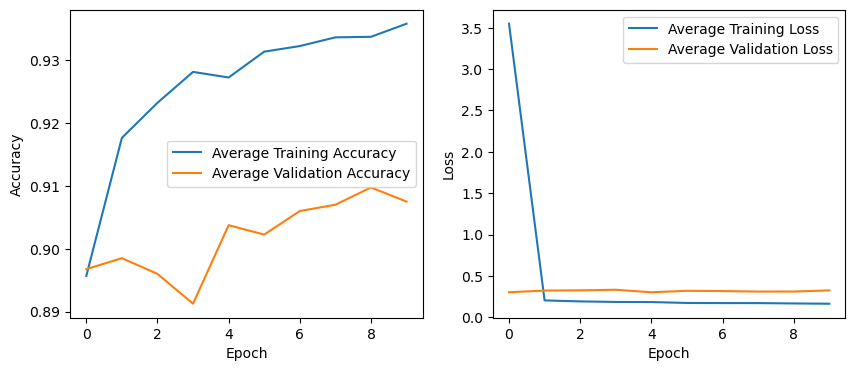

In [9]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Model 1B:** (3, 3) kernel size, 64 filters each

In [10]:
# Define the model
model2 = Sequential()

# Data Augmentation Layers
model2.add(RandomFlip("horizontal"))
model2.add(RandomRotation(0.1))
model2.add(RandomZoom(0.1))
model2.add(RandomContrast(0.1))

# Convolutional Layers
model2.add(Conv2D(64, (3, 3), activation="relu", input_shape=(h, w, 1))) # using 64 rather than 32 filters for this model
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation="relu")) 
model2.add(MaxPooling2D((2, 2)))

# Classification Layers
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation="sigmoid"))  # Output layer

# Compile the model
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [11]:
# Lists to store metrics for each fold
model2_fold_f1_scores = []
model2_fold_histories = []

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2_fold_f1_scores.append(f1_score)
    model2_fold_histories.append(history)

Training for Fold 1
Epoch 1/10


29/29 [==============================] - 145s 5s/step - loss: 16.4693 - accuracy: 0.5567 - precision_1: 0.5571 - recall_1: 0.5528 - auc_1: 0.5525 - val_loss: 0.6009 - val_accuracy: 0.7325 - val_precision_1: 0.7183 - val_recall_1: 0.7650 - val_auc_1: 0.7792
Epoch 2/10
29/29 [==============================] - 141s 5s/step - loss: 0.5828 - accuracy: 0.7331 - precision_1: 0.7271 - recall_1: 0.7461 - auc_1: 0.7882 - val_loss: 0.5180 - val_accuracy: 0.7650 - val_precision_1: 0.7819 - val_recall_1: 0.7350 - val_auc_1: 0.8240
Epoch 3/10
29/29 [==============================] - 141s 5s/step - loss: 0.4706 - accuracy: 0.7806 - precision_1: 0.7824 - recall_1: 0.7772 - auc_1: 0.8583 - val_loss: 0.4756 - val_accuracy: 0.7875 - val_precision_1: 0.8616 - val_recall_1: 0.6850 - val_auc_1: 0.8612
Epoch 4/10
29/29 [==============================] - 141s 5s/step - loss: 0.4990 - accuracy: 0.7719 - precision_1: 0.7933 - recall_1: 0.7356 - auc_1: 0.8456 - val_loss: 0.4965 - val_accuracy: 0.7900 - val_preci

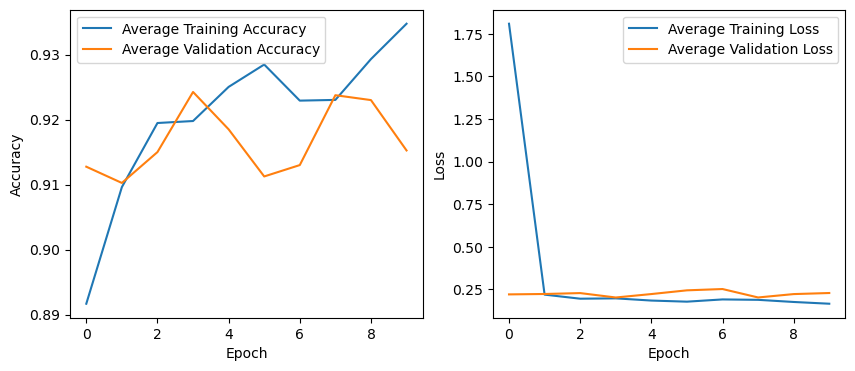

In [12]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model2_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model2_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model2_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model2_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Model 2A:** ResNet with 2 residual blocks

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Add, 
                                     Activation, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)

# Define input shape and hyperparameters
h, w, l = 100, 100, 1  # Image dimensions and channels (grayscale)
filters_initial = 32
filters_residual = 64

# Define the input layer
input_layer = Input(shape=(h, w, l))

# Data Augmentation
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Layer
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)  # Use 64 filters
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
shortcut1 = x  # Save the input to the residual block
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut1])  # Add the residual connection
x = Activation("relu")(x)

# Residual Block 2
shortcut2 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut2])
x = Activation("relu")(x)

# Classification Layers
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation="sigmoid")(x)

# Create the ResNet model
model2A = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2A.compile(loss="binary_crossentropy", optimizer="adam", 
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [14]:
# Lists to store metrics for each fold
model2A_fold_f1_scores = []
model2A_fold_histories = []

# Number of epochs (adjust as needed)
epochs = 10 

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2A.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2A.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2A_fold_f1_scores.append(f1_score)
    model2A_fold_histories.append(history)

Training for Fold 1
Epoch 1/10
29/29 [==============================] - 149s 5s/step - loss: 45.1295 - accuracy: 0.5169 - precision_2: 0.5193 - recall_2: 0.4567 - auc_2: 0.5149 - val_loss: 0.6617 - val_accuracy: 0.5825 - val_precision_2: 0.7538 - val_recall_2: 0.2450 - val_auc_2: 0.6975
Epoch 2/10
29/29 [==============================] - 143s 5s/step - loss: 0.6160 - accuracy: 0.6600 - precision_2: 0.6814 - recall_2: 0.6011 - auc_2: 0.7229 - val_loss: 0.6083 - val_accuracy: 0.7150 - val_precision_2: 0.6903 - val_recall_2: 0.7800 - val_auc_2: 0.7962
Epoch 3/10
29/29 [==============================] - 143s 5s/step - loss: 0.5329 - accuracy: 0.7458 - precision_2: 0.7639 - recall_2: 0.7117 - auc_2: 0.8133 - val_loss: 0.5132 - val_accuracy: 0.7550 - val_precision_2: 0.7525 - val_recall_2: 0.7600 - val_auc_2: 0.8339
Epoch 4/10
29/29 [==============================] - 143s 5s/step - loss: 0.5145 - accuracy: 0.7606 - precision_2: 0.7836 - recall_2: 0.7200 - auc_2: 0.8281 - val_loss: 0.4861 - v

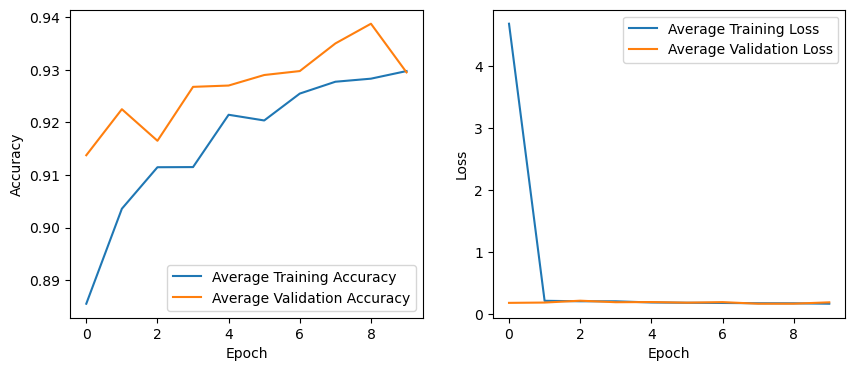

In [15]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model2A_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model2A_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model2A_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model2A_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Model 2B:** ResNet with 3 residual blocks

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Add, 
                                     Activation, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)

# Define input shape and hyperparameters
h, w, l = 100, 100, 1  # Image dimensions and channels (grayscale)
filters_initial = 32
filters_residual = 64

# Define the input layer
input_layer = Input(shape=(h, w, l))

# Data Augmentation
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Layer
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)  # Use 64 filters
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
shortcut1 = x  # Save the input to the residual block
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut1])  # Add the residual connection
x = Activation("relu")(x)

# Residual Block 2
shortcut2 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut2])
x = Activation("relu")(x)

# *** Additional Residual Block 3 ***
shortcut3 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut3])
x = Activation("relu")(x)

# Classification Layers (modified dropout)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)  # Dropout before the first dense layer
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)  # Dropout before the output layer
output_layer = Dense(1, activation="sigmoid")(x)

# Create the ResNet model
model2B = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2B.compile(loss="binary_crossentropy", optimizer="adam", 
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [ ]:
# Lists to store metrics for each fold
model2B_fold_f1_scores = []
model2B_fold_histories = []

# Number of epochs (adjust as needed)
epochs = 10 

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2B.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2B.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2B_fold_f1_scores.append(f1_score)
    model2B_fold_histories.append(history)

> [1.5 points] Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work (1 points total)